In [3]:
from __future__ import print_function

import sys
import socket

if socket.gethostname() == "qiaubuntu" or socket.gethostname() == "toologic-ubuntu2":
    sys.path.extend(['/home/jorg/repository/seg_eval_pipeline'])
else:
    sys.path.extend(['/home/jorg/repo/seg_eval_pipeline'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import torch

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from plotting.color_maps import transparent_cmap 
from core.region_detector.process_heat_maps import SimulateExpert
from config.region_detector.general_setup import config_detector
from config.dcnn_mc.general_setup import base_config as config_acdc
from io_tools.acdc.data_handler import ACDCDataHandler
from core.acdc.acdc_fold_eval import FoldEvaluation

from plotting.seg_errors_and_maps import plot_slices

mycmap = transparent_cmap(plt.get_cmap('jet'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
fold_id = 1
patient_ids = None # ["patient011", "patient012", "patient013"] #  fold1: ["patient011", "patient012", "patient013"]
# fold0:["patient016","patient017", "patient018", "patient019", "patient020"]
sim_expert = SimulateExpert(model_name="rd1", fold_id=fold_id, type_of_map="e_map", app_config=config_detector,
                                patient_ids=patient_ids, verbose=False, correct_all_seg_errors=True)
sim_expert()
print("Evaluation-before")
sim_expert._eval_before_correction()
sim_expert.save()
print("Ready")

100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Evaluation-before
INFO - Successfully saved eval-results to /home/jorg/repository/seg_eval_pipeline/data/Folds/fold1/results/rd1/e_map/25_f1_seg_evaluation_best
INFO - Successfully saved eval-results to /home/jorg/repository/seg_eval_pipeline/data/Folds/fold1/results/rd1/e_map/25_f1_seg_evaluation_baseline
Ready


In [3]:

sim_expert_rd1 = SimulateExpert(model_name="rd1", fold_id=fold_id, type_of_map="e_map", app_config=config_detector,
                                patient_ids=patient_ids, verbose=False, correct_all_seg_errors=False)
sim_expert_rd1()
print("Evaluation-before")
sim_expert_rd1._eval_before_correction()
sim_expert_rd1.save()
print("Ready")

100%|██████████| 25/25 [00:04<00:00,  5.45it/s]


Evaluation-before
INFO - Successfully saved eval-results to /home/jorg/repository/seg_eval_pipeline/data/Folds/fold1/results/rd1/e_map/25_f1_seg_evaluation
INFO - Successfully saved eval-results to /home/jorg/repository/seg_eval_pipeline/data/Folds/fold1/results/rd1/e_map/25_f1_seg_evaluation_baseline
Ready


In [9]:
sim_expert.free_memory()

INFO - Successfully saved fig /home/jorg/repository/seg_eval_pipeline/data/Folds/fold1/results/figures/rd1/e_map/DSC_box_plot.pdf


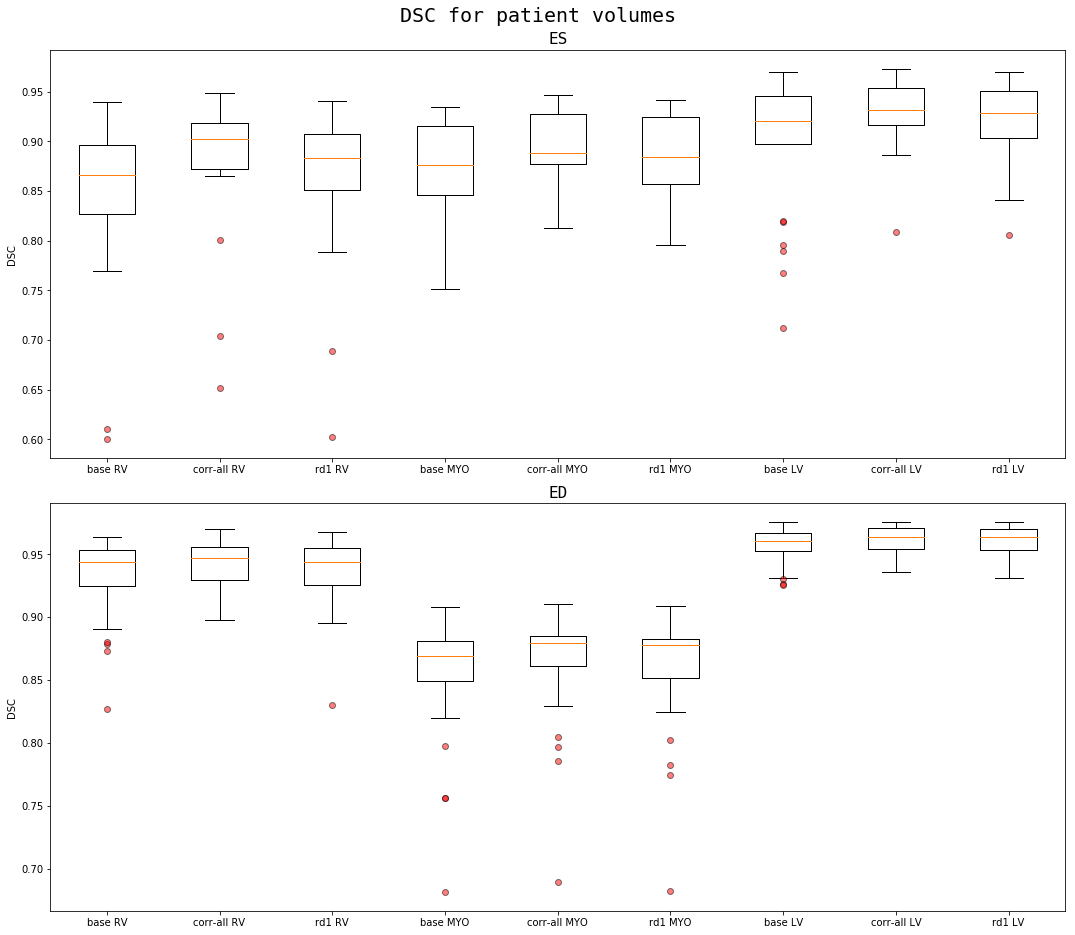

In [30]:
from plotting.box_plots import make_volume_box_plots

perf_type = "DSC"  # HD or DSC only

path_list = [sim_expert_rd1.app_config.data_dir, "fold" + str(sim_expert_rd1.fold_id), "results", "figures", \
             sim_expert_rd1.model_name, sim_expert_rd1.type_of_map]


eval_dice_list, eval_hd_list = sim_expert_rd1.get_boxplot_vectors(base_obj=False)
# this is our benchmark, if we would have detected ALL seg-errors for this model
eval_dice_list_bmark, eval_hd_list_bmark = sim_expert.get_boxplot_vectors(base_obj=False)
# this is our baseline, the performance of the segmentation model BEFORE detection
eval_dice_list_base, eval_hd_list_base = sim_expert.get_boxplot_vectors(base_obj=True)

if perf_type == "DSC":
    list_of_vectors = [eval_dice_list_base, eval_dice_list_bmark, eval_dice_list]
else:
    list_of_vectors = [eval_hd_list_base, eval_hd_list_bmark, eval_hd_list]
list_of_labels = ["base", "corr-all", "rd1"]

make_volume_box_plots(list_of_vectors, list_of_labels, do_show=True, do_save=True, perf_type=perf_type,
                      path_list=path_list, height=20)

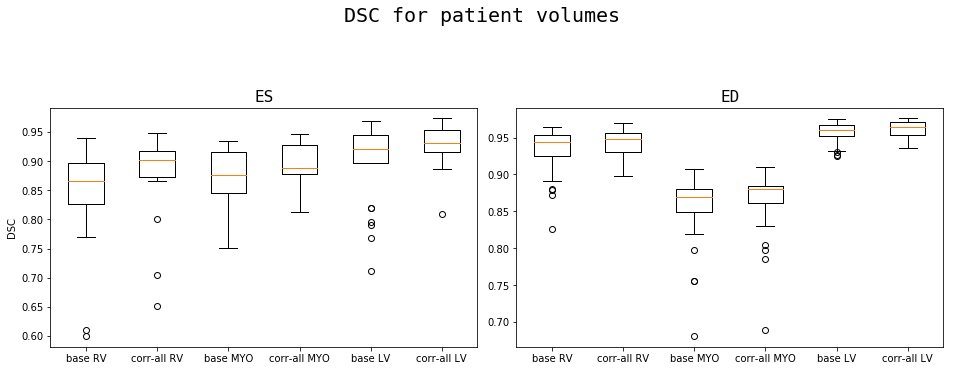

In [9]:
from plotting.box_plots import make_volume_box_plots

eval_dice_list, eval_hd_list = sim_expert.get_boxplot_vectors(base_obj=False)
eval_dice_list_base, eval_hd_list_base = sim_expert.get_boxplot_vectors(base_obj=True)

list_of_vectors = [eval_dice_list_base, eval_dice_list]
list_of_labels = ["base", "corr-all"]

make_volume_box_plots(list_of_vectors, list_of_labels, do_show=True, do_save=False)

In [7]:
fold_id = 1
patient_ids = None
model_name = "rd1"

sim_expert = SimulateExpert(model_name=model_name, fold_id=fold_id, type_of_map="e_map", 
                            app_config=config_detector,
                            patient_ids=patient_ids, verbose=False, correct_all_seg_errors=True)
sim_expert.load_results()
sim_expert.load_baseline()

INFO - Successfully loaded numpy archives from /home/jorg/repository/seg_eval_pipeline/data/Folds/fold1/results/rd1/e_map/25_f1_seg_evaluation_benchmark.npz
INFO - Successfully loaded numpy archives from /home/jorg/repository/seg_eval_pipeline/data/Folds/fold1/results/rd1/e_map/25_f1_seg_evaluation_baseline.npz


In [8]:
sim_expert_rd1 = SimulateExpert(model_name=model_name, fold_id=fold_id, type_of_map="e_map", 
                                app_config=config_detector,
                                patient_ids=patient_ids, verbose=False, correct_all_seg_errors=False)
sim_expert_rd1.load_results()
sim_expert_rd1.load_baseline()

INFO - Successfully loaded numpy archives from /home/jorg/repository/seg_eval_pipeline/data/Folds/fold1/results/rd1/e_map/25_f1_seg_evaluation.npz
INFO - Successfully loaded numpy archives from /home/jorg/repository/seg_eval_pipeline/data/Folds/fold1/results/rd1/e_map/25_f1_seg_evaluation_baseline.npz


In [11]:
sim_expert.compare_results(patient_ids=None)

------------------------- patient016 --------------------
before: dice(RV/Myo/LV):	ES 0.87/0.85/0.96	ED 0.94/0.85/0.97
after : dice(RV/Myo/LV):	ES 0.94/0.85/0.96	ED 0.94/0.85/0.97
before: Hausdorff(RV/Myo/LV):	ES 8.85/4.43/3.43	ED 23.34/4.43/3.13
after : Hausdorff(RV/Myo/LV):	ES 8.85/4.43/3.43	ED 17.09/4.43/3.13
------------------------- patient017 --------------------
before: dice(RV/Myo/LV):	ES 0.93/0.86/0.97	ED 0.96/0.84/0.97
after : dice(RV/Myo/LV):	ES 0.94/0.86/0.97	ED 0.96/0.84/0.98
before: Hausdorff(RV/Myo/LV):	ES 5.77/16.92/4.20	ED 4.20/16.92/4.20
after : Hausdorff(RV/Myo/LV):	ES 5.77/5.60/3.96	ED 4.20/5.60/3.43
------------------------- patient018 --------------------
before: dice(RV/Myo/LV):	ES 0.94/0.87/0.97	ED 0.94/0.84/0.97
after : dice(RV/Myo/LV):	ES 0.94/0.87/0.97	ED 0.95/0.84/0.97
before: Hausdorff(RV/Myo/LV):	ES 5.24/4.43/3.96	ED 14.07/4.43/2.42
after : Hausdorff(RV/Myo/LV):	ES 5.77/4.43/3.96	ED 8.52/4.43/2.42
------------------------- patient019 --------------------
b

In [10]:
sim_expert_rd1.compare_results(patient_ids=None)

------------------------- patient016 --------------------
before: dice(RV/Myo/LV):	ES 0.87/0.85/0.96	ED 0.94/0.85/0.97
after : dice(RV/Myo/LV):	ES 0.92/0.85/0.96	ED 0.94/0.85/0.97
before: Hausdorff(RV/Myo/LV):	ES 8.85/4.43/3.43	ED 23.34/4.43/3.13
after : Hausdorff(RV/Myo/LV):	ES 8.85/4.43/3.43	ED 17.09/4.43/3.13
------------------------- patient017 --------------------
before: dice(RV/Myo/LV):	ES 0.93/0.86/0.97	ED 0.96/0.84/0.97
after : dice(RV/Myo/LV):	ES 0.94/0.86/0.97	ED 0.96/0.84/0.97
before: Hausdorff(RV/Myo/LV):	ES 5.77/16.92/4.20	ED 4.20/16.92/4.20
after : Hausdorff(RV/Myo/LV):	ES 5.77/5.60/3.96	ED 4.20/5.60/4.20
------------------------- patient018 --------------------
before: dice(RV/Myo/LV):	ES 0.94/0.87/0.97	ED 0.94/0.84/0.97
after : dice(RV/Myo/LV):	ES 0.94/0.87/0.97	ED 0.95/0.84/0.97
before: Hausdorff(RV/Myo/LV):	ES 5.24/4.43/3.96	ED 14.07/4.43/2.42
after : Hausdorff(RV/Myo/LV):	ES 5.77/4.43/3.96	ED 8.52/4.43/2.42
------------------------- patient019 --------------------
b

In [29]:
data_handler = ACDCDataHandler(apps_config=config_acdc)

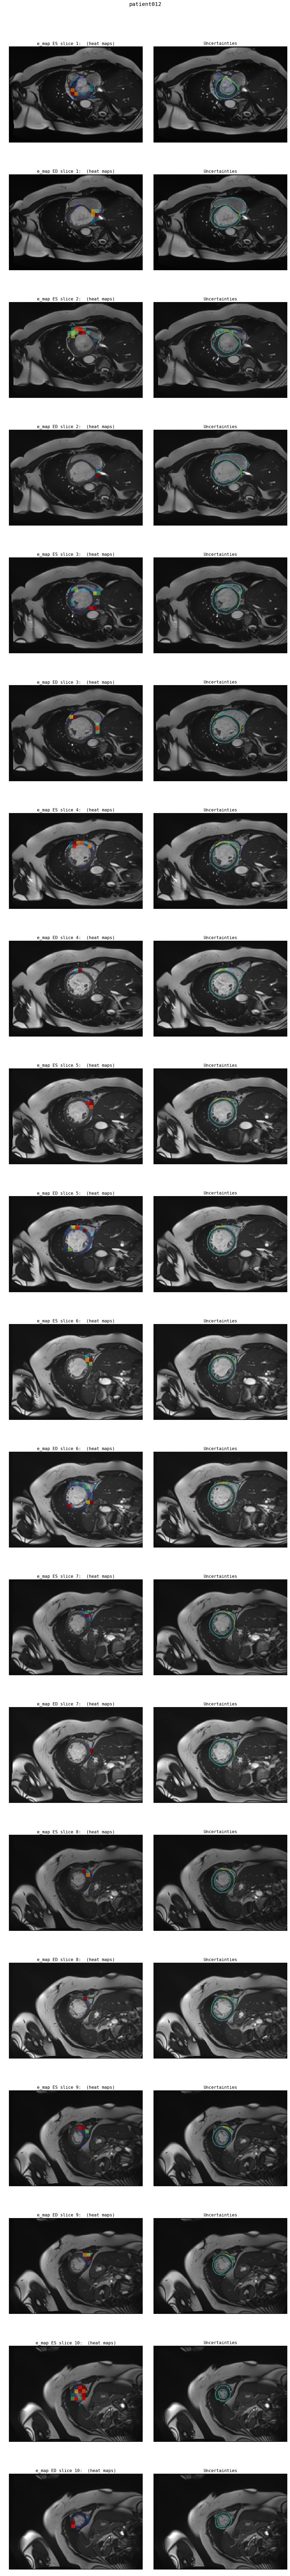

In [33]:
fold_id = 1
patient_id = "patient012"

# left_column_overlay = [None, "map", "error_roi", "heat_map"]   
# right_column_overlay=[None, "error", "ref", "auto"]
plot_slices(data_handler, patient_id=patient_id, do_show=True, do_save=False, rd_model_name="rd1", 
            slice_range=None, type_of_map="e_map", aggregate_func="max", right_column_overlay="map",
            left_column_overlay="heat_map")